# FFT the Arctic

![https://xkcd.com/26/](https://imgs.xkcd.com/comics/fourier.jpg)

This notebook demonstrates how to perform spectral analyses on gridded topographic data at scale for the purposes of analyzing Arctic topography from various sources. 
1) I show how to load in and read lidar-derived topographic data for an area of interest (AOI)
2) I show how to query, download, and crop ArcticDEM from the Polar Geospatial Center for the same AOI
3) I show how Earth Engine can be used to query topographic (and multispectral!) data for the same AOI
4) I modify [Ben Purinton's Python version](https://github.com/bpurinton/DEM-FFT) of Taylor Perron's 2D spectral analysis to perform a 2D fast Fourier transform on all of the above data. 

In [1]:
import ee

import geopandas as gpd

from pyproj import CRS, Transformer
import pyproj

import pandas as pd

# import some python packages
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import warnings

from shapely.geometry import mapping
# from shapely.ops import transform


from pathlib import Path
import glob

# ignore some warnings
warnings.filterwarnings('ignore')
import scipy.signal

import rasterio
from rasterio.mask import mask


# Setup

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

The first two functions just modify the `FFT-DEM` repo, and then the third is a simple curvature function that I had ChatGPT write  

In [3]:
def fourier_2d_dem(z, step):
    # get the size of the raster and save a copy of the original grid
    z_original = z.copy()
    ny, nx = z.shape

    # use linear algebra to fit a plane by least squares
    x, y = np.meshgrid(range(nx), range(ny))
    A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
    fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
    z = z - (fit[0]*x + fit[1]*y + fit[2])

    # apply hanning windowing to reduce spectral leakage on edges
    hann_y = np.hanning(ny)
    hann_x = np.hanning(nx)
    hann_2d = np.sqrt(np.outer(hann_y, hann_x))
    hann_weight = np.sum(hann_2d ** 2)
    z = z * hann_2d

    # This next step is done to optimize the Cooley and Turkey (1965)
    # Discrete Fourier Transfom (DFT) method used by numpy, which operates
    # most efficiently when the length scales are powers of 2 and the grid
    # is square
    Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
    Ly = Lx

    # run the fft
    fft = np.fft.fftn(z, (Ly, Lx))

    # shift zero frequency to center
    fft_shift = np.fft.fftshift(fft)

    # # index of zero frequency (DC component)
    xc, yc = (Lx//2, Ly//2)

    # # zero out the DC component
    fft_shift[yc, xc] = 0

    # get the DFT periodogram with units of m^2 for topography
    # include weights of hann to correct for windowing
    p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

    # The periodogram is a measure of how much of the
    # original elevation field's variance falls within a given frequency range.
    # You can check that the sum of the periodogram is roughly equal to the
    # variance in Z. (The variance will be somewhat less due to the zero padding.)

    # calculate radial frequencies
    # xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
    x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

    # wavenumbers
    kx = x - xc
    ky = y - yc
    # kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

    # radial frequencies
    fx = kx / (Lx * step)
    fy = ky / (Ly * step)
    f2d = np.sqrt(fx**2 + fy**2)
    # w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
    # f2d = 1/w2d

    # fourier angles
    F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

    # Create sorted, non-redundant vectors of frequency and power
    p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
    f1d = f2d[:, 0:xc+1].copy() # same for the frequency
    F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

    # set reundant columns to negative for clipping below
    f1d[yc:Ly, xc] = -1

    # concatenate frequency and power and sort by frequency
    f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
    I = np.argsort(f1d[:, 0])
    f1d = f1d[I, :]

    # remove negative values
    f1d = f1d[f1d[:, 0] > 0, :]

    # extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
    p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
    F_ang1d = f1d[:, 2]
    f1d = f1d[:, 0]

    # bin the data using log bins
    # bins = 20
    # f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)

    a1=10.**(np.arange(-4, 0)) 
    a2 = np.arange(1,10,0.5)
    bin_edges=np.outer(a1, a2).flatten()

    bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_max, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_center = edges[:-1] + np.diff(edges)/2

    # sometimes NaN values remain in some bins, throw those bins out
    bin_center = bin_center[np.isfinite(bin_med)]
    bin_med = bin_med[np.isfinite(bin_med)]
    bin_max = bin_max[np.isfinite(bin_max)]

    # apply a power-law fit to the bins
    A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
    fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
    pl_fit = (10**fit[1]) * (bin_center**fit[0])

    # use the power-law fit to normalize the 1D spectrum
    p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

    # Get max of normalized values
    norm_bin_max, edges, _ = stats.binned_statistic(f1d, p1d_norm, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )

    norm_bin_max = norm_bin_max[np.isfinite(norm_bin_max)]

    return bin_center, bin_max, norm_bin_max 

In [4]:
def fourier_2d_nofit(z, step):
    # get the size of the raster and save a copy of the original grid
    z_original = z.copy()
    ny, nx = z.shape

    # # use linear algebra to fit a plane by least squares
    # x, y = np.meshgrid(range(nx), range(ny))
    # A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
    # fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
    # z = z - (fit[0]*x + fit[1]*y + fit[2])

    # apply hanning windowing to reduce spectral leakage on edges
    hann_y = np.hanning(ny)
    hann_x = np.hanning(nx)
    hann_2d = np.sqrt(np.outer(hann_y, hann_x))
    hann_weight = np.sum(hann_2d ** 2)
    z = z * hann_2d

    # This next step is done to optimize the Cooley and Turkey (1965)
    # Discrete Fourier Transfom (DFT) method used by numpy, which operates
    # most efficiently when the length scales are powers of 2 and the grid
    # is square
    Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
    Ly = Lx

    # run the fft
    fft = np.fft.fftn(z, (Ly, Lx))

    # shift zero frequency to center
    fft_shift = np.fft.fftshift(fft)

    # # index of zero frequency (DC component)
    xc, yc = (Lx//2, Ly//2)

    # # zero out the DC component
    fft_shift[yc, xc] = 0

    # get the DFT periodogram with units of m^2 for topography
    # include weights of hann to correct for windowing
    p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

    # The periodogram is a measure of how much of the
    # original elevation field's variance falls within a given frequency range.
    # You can check that the sum of the periodogram is roughly equal to the
    # variance in Z. (The variance will be somewhat less due to the zero padding.)

    # calculate radial frequencies
    # xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
    x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

    # wavenumbers
    kx = x - xc
    ky = y - yc
    # kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

    # radial frequencies
    fx = kx / (Lx * step)
    fy = ky / (Ly * step)
    f2d = np.sqrt(fx**2 + fy**2)
    # w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
    # f2d = 1/w2d

    # fourier angles
    F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

    # Create sorted, non-redundant vectors of frequency and power
    p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
    f1d = f2d[:, 0:xc+1].copy() # same for the frequency
    F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

    # set reundant columns to negative for clipping below
    f1d[yc:Ly, xc] = -1

    # concatenate frequency and power and sort by frequency
    f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
    I = np.argsort(f1d[:, 0])
    f1d = f1d[I, :]

    # remove negative values
    f1d = f1d[f1d[:, 0] > 0, :]

    # extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
    p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
    F_ang1d = f1d[:, 2]
    f1d = f1d[:, 0]

    # bin the data using log bins
    # bins = 20
    # f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)

    a1=10.**(np.arange(-4, 0)) 
    a2 = np.arange(1,10,0.5)
    bin_edges=np.outer(a1, a2).flatten()

    bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_max, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )
    bin_center = edges[:-1] + np.diff(edges)/2

    # sometimes NaN values remain in some bins, throw those bins out
    bin_center = bin_center[np.isfinite(bin_med)]
    bin_med = bin_med[np.isfinite(bin_med)]
    bin_max = bin_max[np.isfinite(bin_max)]

    # apply a power-law fit to the bins
    A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
    fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
    pl_fit = (10**fit[1]) * (bin_center**fit[0])

    # use the power-law fit to normalize the 1D spectrum
    p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

    # Get max of normalized values
    norm_bin_max, edges, _ = stats.binned_statistic(f1d, p1d_norm, statistic=np.nanmax,
                                    # bins=f_bins
                                    bins=bin_edges
                                    )

    norm_bin_max = norm_bin_max[np.isfinite(norm_bin_max)]

    return bin_center, bin_max, norm_bin_max 

In [5]:
def derive_curvature(elevation, window_size):
    # Compute first derivatives with a moving window
    dx = scipy.signal.convolve2d(elevation, np.array([[-1, 0, 1]]), mode='same') / 2
    dy = scipy.signal.convolve2d(elevation, np.array([[-1], [0], [1]]), mode='same') / 2

    # Compute second derivatives with a moving window
    dxx = scipy.signal.convolve2d(dx, np.array([[-1, 0, 1]]), mode='same') / 2
    dyy = scipy.signal.convolve2d(dy, np.array([[-1], [0], [1]]), mode='same') / 2

    # Calculate curvature
    curvature = (dxx + dyy) / (1 + dx**2 + dy**2)**1.5

    return curvature

This script takes advantage of the `ee.data.computePixels()` function to bypass downloading GeoTIFFs and instead just grabs the elevation data as a numpy structured array.

In [6]:
def get_ee_data(roi_square):
    # Define the time range for Sentinel-2 data
    start_date = '2021-06-30'
    end_date = '2021-09-30'

    # Filter Sentinel-2 data
    sentinel2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                            .filterBounds(roi_square)
                            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                            .filterDate(ee.Date(start_date), ee.Date(end_date)))


    # Function to calculate NDVI
    def calculate_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    # Map the NDVI function over the collection
    sentinel2_with_ndvi = sentinel2_collection.map(calculate_ndvi)
  
    # Load ArcticDEM dataset
    arctic_dem = ee.Image('UMN/PGC/ArcticDEM/V3/2m_mosaic')

    dem_roi = arctic_dem.clip(roi_square)
    hs_roi = ee.Terrain.hillshade(arctic_dem).clip(roi_square)
    
    data_npy = ee.data.computePixels({
        'expression': dem_roi.clip(roi_square),
        'fileFormat': 'NUMPY_NDARRAY'
    })

    hs_npy = ee.data.computePixels({
        'expression': (hs_roi
                    #  .resample('bicubic').reproject(crs=f'EPSG:{epsg}', scale=2)
        .clip(roi_square)),
        'fileFormat': 'NUMPY_NDARRAY'
    })

    ndvi_npy = ee.data.computePixels({
        'expression':sentinel2_with_ndvi.select('NDVI')
        # .reduce(ee.Reducer.mean())
        .first()
        .clip(roi_square),
        'fileFormat': 'NUMPY_NDARRAY'
    })
    elevation = data_npy['elevation']
            

    hs = hs_npy['hillshade']
    hs = np.ma.masked_where(hs == 0, hs)

    ndvi = ndvi_npy['NDVI']
    ndvi = np.ma.masked_where(ndvi == 0, ndvi)

    return elevation, hs, ndvi

In [7]:
a1=10.**(np.arange(-4, 0)) 
a2 = np.arange(1,10,0.5)
bin_edges=np.outer(a1, a2).flatten()

# Load data and analyze lidar data

I went ahead and grabbed lat-longs for the four NGEE Arctic sites for which I knew there would be lidar data for (which is in the `data` directory already downloaded.)

In [8]:
df = pd.read_csv("site_centroids_ncalm.csv")

gdf = (
    gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long_dd, df.lat_dd), crs='epsg:4326')
    .to_crs("EPSG:3413")
)

gdf['bbox_geom'] = gdf.geometry.buffer(2000, cap_style=3)

gdf = gdf.set_geometry(gdf['bbox_geom'])

gdf

,site,long_dd,lat_dd,data,file,geometry,bbox_geom
0,t47,-166.236575,65.011209,ncalm,TLRN_GEF_01M.tif,"POLYGON ((-2348466.395 1427544.594, -2348466.3...","POLYGON ((-2348466.395 1427544.594, -2348466.3..."
1,t27,-166.010027,64.776650,ncalm,TLRS_GEF_01M_V2.tif,"POLYGON ((-2376899.746 1431953.855, -2376899.7...","POLYGON ((-2376899.746 1431953.855, -2376899.7..."
2,koug,-164.758262,65.168131,ncalm,KGRKS_GEF_01M.tif,"POLYGON ((-2369012.062 1357598.660, -2369012.0...","POLYGON ((-2369012.062 1357598.660, -2369012.0..."
3,council,-163.766552,64.839209,ncalm,CNCL_GEF_01M.tif,"POLYGON ((-2424827.799 1334315.558, -2424827.7...","POLYGON ((-2424827.799 1334315.558, -2424827.7..."


This script also takes the lat/long of these points and downloads the Earth Engine-hosted ArcticDEM for the same AOI, and then performs the FFT on that data. 

In [9]:
site_dict = {}

for site in gdf['site'].to_list():
    print(f'Now on {site}') 
    data_dict = {}

    fname = gdf.loc[gdf['site']==site]['file'].values[0]
    with rasterio.open(f'data/{fname}') as src:

        geometry = gdf.loc[gdf['site']==site].to_crs(src.crs).geometry.to_list()[0]
        
        # Crop the GeoTIFF using the shapefile geometry
        cropped, _ = mask(src, [mapping(geometry)], crop=True)

        # Get the metadata of the original GeoTIFF
        meta = src.meta.copy()

        # Update metadata with the new dimensions and transform
        # meta.update({
        #     'height': cropped.shape[1],
        #     'width': cropped.shape[2],
        #     'transform': rasterio.windows.transform(window=src.window(*geometry.bounds))
        # })

        # Read the cropped area as a NumPy array
        cropped_array = cropped[0, :, :]
        cropped_array = np.ma.masked_where(cropped_array < 0, cropped_array)
    
    bin_center, bin_max, norm_bin_max = fourier_2d_dem(cropped_array, 1)

    data_dict['lidar_bin_max'] = bin_max
    data_dict['lidar_norm_bin_max'] = norm_bin_max
    data_dict['lidar_bin_center'] = bin_center

    curvature = derive_curvature(cropped_array, 20)

    bin_center, bin_max, norm_bin_max = fourier_2d_nofit(curvature, 1)
    
    data_dict['curv_lidar_bin_max'] = bin_max
    data_dict['curv_lidar_norm_bin_max'] = norm_bin_max
    data_dict['curv_lidar_bin_center'] = bin_center




Now on t47
Now on t27
Now on koug


KeyboardInterrupt: 

In [ ]:
for site in gdf['site'].to_list():
    print(f'Now on {site}') 
    data_dict = {}

    fname = gdf.loc[gdf['site']==site]['file'].values[0]
    with rasterio.open(f'data/{fname}') as src:

        geometry = gdf.loc[gdf['site']==site].to_crs(src.crs).geometry.to_list()[0]
        
        # Crop the GeoTIFF using the shapefile geometry
        cropped, _ = mask(src, [mapping(geometry)], crop=True)

        # Get the metadata of the original GeoTIFF
        meta = src.meta.copy()

        # Update metadata with the new dimensions and transform
        # meta.update({
        #     'height': cropped.shape[1],
        #     'width': cropped.shape[2],
        #     'transform': rasterio.windows.transform(window=src.window(*geometry.bounds))
        # })

        # Read the cropped area as a NumPy array
        cropped_array = cropped[0, :, :]
        cropped_array = np.ma.masked_where(cropped_array < 0, cropped_array)    
    long = gdf.loc[gdf['site']==site].long_dd.values[0]
    lat = gdf.loc[gdf['site']==site].lat_dd.values[0]

    roi_point = ee.Geometry.Point([long, lat])

    roi_square = roi_point.buffer(2000).bounds()

    elevation, _, ndvi, = get_ee_data(roi_square)

    bin_center, bin_max, norm_bin_max = fourier_2d_dem(elevation, 2)

    
    data_dict['bin_max'] = bin_max
    data_dict['norm_bin_max'] = norm_bin_max
    data_dict['bin_center'] = bin_center

    curvature = derive_curvature(elevation, 20)

    bin_center, bin_max, norm_bin_max = fourier_2d_nofit(curvature, 2)

    data_dict['curv_bin_max'] = bin_max
    data_dict['curv_norm_bin_max'] = norm_bin_max
    data_dict['curv_bin_center'] = bin_center

    bin_center, bin_max, norm_bin_max = fourier_2d_nofit(ndvi, 10)

    data_dict['ndvi_bin_max'] = bin_max
    data_dict['ndvi_norm_bin_max'] = norm_bin_max
    data_dict['ndvi_bin_center'] = bin_center

    site_dict[site] = data_dict

## Plot results

### Lidar DEM

Text(0, 0.5, 'Normalized power, bin max\nLidar elevation')

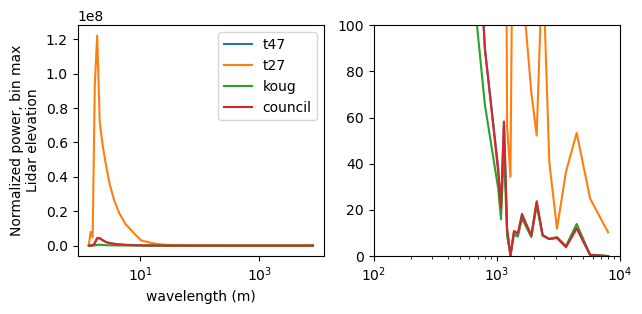

In [121]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
for site, data_dict in site_dict.items():
    ax[0].semilogx(1/data_dict['lidar_bin_center'], data_dict['lidar_norm_bin_max'], label=site)
    ax[1].semilogx(1/data_dict['lidar_bin_center'], data_dict['lidar_norm_bin_max'], label=site)
    ax[0].legend()
    ax[1].set_xlim(1e2,1e4)
    ax[1].set_ylim(0,100)

ax[0].set_xlabel('wavelength (m)')
ax[0].set_ylabel('Normalized power, bin max\nLidar elevation')

### Lidar curvature

Text(0, 0.5, 'Normalized power, bin max\nLidar curvature')

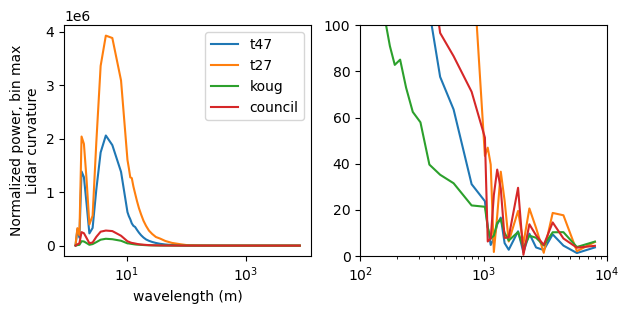

In [122]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
for site, data_dict in site_dict.items():
    ax[0].semilogx(1/data_dict['curv_lidar_bin_center'], data_dict['curv_lidar_norm_bin_max'], label=site)
    ax[1].semilogx(1/data_dict['curv_lidar_bin_center'], data_dict['curv_lidar_norm_bin_max'], label=site)
    ax[0].legend()
    ax[1].set_xlim(1e2,1e4)
    ax[1].set_ylim(0,100)

ax[0].set_xlabel('wavelength (m)')
ax[0].set_ylabel('Normalized power, bin max\nLidar curvature')

### Earth Engine-hosted ArcticDEM DEM

Text(0, 0.5, 'Normalized power, bin max\nArcticDEM elevation')

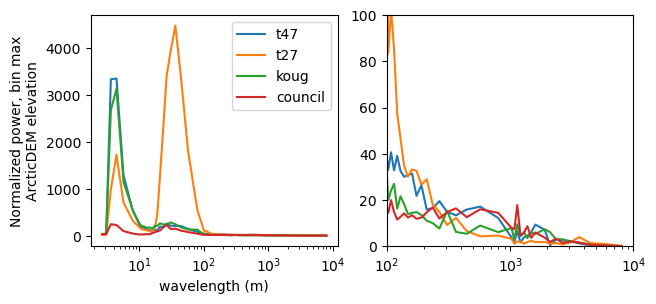

In [129]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
for site, data_dict in site_dict.items():
    ax[0].semilogx(1/data_dict['bin_center'], data_dict['norm_bin_max'], label=site)
    ax[1].semilogx(1/data_dict['bin_center'], data_dict['norm_bin_max'], label=site)
    ax[0].legend()
    ax[1].set_xlim(1e2,1e4)
    ax[1].set_ylim(0,100)

ax[0].set_xlabel('wavelength (m)')
ax[0].set_ylabel('Normalized power, bin max\nArcticDEM elevation')

### Earth Engine-hosted ArcticDEM curvature

Text(0, 0.5, 'Normalized power, bin max\nArcticDEM curvature')

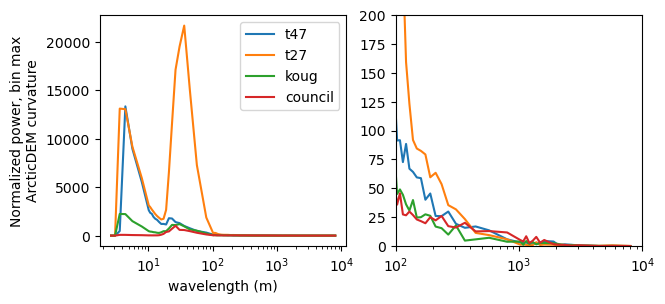

In [130]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
for site, data_dict in site_dict.items():
    ax[0].semilogx(1/data_dict['curv_bin_center'], data_dict['curv_norm_bin_max'], label=site)
    ax[1].semilogx(1/data_dict['curv_bin_center'], data_dict['curv_norm_bin_max'], label=site)
    ax[0].legend()
    ax[1].set_xlim(1e2,1e4)
    ax[1].set_ylim(0,200)

ax[0].set_xlabel('wavelength (m)')
ax[0].set_ylabel('Normalized power, bin max\nArcticDEM curvature')

### Earth Engine-hosted Sentinel 2 derived NDVI, for kicks

Text(0, 0.5, 'Normalized power, bin max\nNDVI via Sentinel-2')

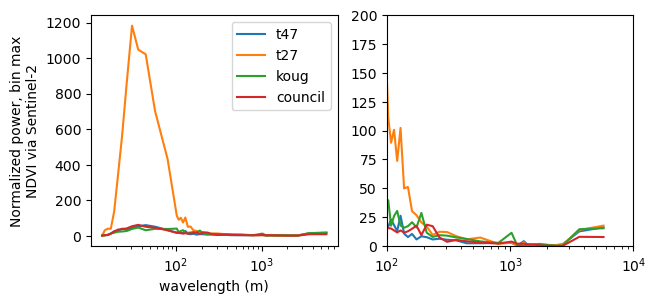

In [127]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=100)
for site, data_dict in site_dict.items():
    ax[0].semilogx(1/data_dict['ndvi_bin_center'], data_dict['ndvi_norm_bin_max'], label=site)
    ax[1].semilogx(1/data_dict['ndvi_bin_center'], data_dict['ndvi_norm_bin_max'], label=site)
    # ax[0].set_ylim(0,100)
    ax[0].legend()
    ax[1].set_xlim(1e2,1e4)
    ax[1].set_ylim(0,200)

ax[0].set_xlabel('wavelength (m)')
ax[0].set_ylabel('Normalized power, bin max\nNDVI via Sentinel-2')

# Get ArcticDEM for the same AOI from the PGC

In [ ]:
# tiles = gpd.read_file("data/ArcticDEM_Mosaic_Index_v4_1_2m.shp")
tiles = gpd.read_file('data/ArcticDEM_Strip_Index_s2s041.shp')

intersecting_polygons = gpd.sjoin(gdf.to_crs('epsg:4326'), tiles)

# intersecting_polygons['fileurl'].unique()

# We're going to let this marinate for a bit because these files are too huge

In [ ]:
strips = tiles[tiles['dem_id'].isin(intersecting_polygons['dem_id'])]
good_strips = strips.loc[strips['valid_perc']>.99]

In [ ]:
fig, ax = plt.subplots()
im0=good_strips.boundary.plot(alpha=0.5, ax=ax)
im1=intersecting_polygons.plot(ax=ax)

## Download the first strip in the list of strips that wholly contain the sites

In [ ]:
for site in intersecting_polygons['site'].unique():
    # print(good_strips[good_strips.contains(intersecting_polygons.loc[intersecting_polygons['site']==site].unary_union)]['fileurl'].sample())

    folder_path = Path(site)
    folder_path.mkdir(exist_ok=True)  # Create the folder if it doesn't exist

    # Generate the URL for the file
    file_url = good_strips[good_strips.contains(intersecting_polygons.loc[intersecting_polygons['site']==site].unary_union)]['fileurl'].sample().values[0]

    # Download the file
    response = requests.get(file_url)
    file_path = folder_path / f'{site}.tar.gz'

    with open(file_path, 'wb') as file:
        file.write(response.content)

    print(f"File '{file_url}' downloaded to '{folder_path}'.")

    # Unzip the .tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=folder_path)

In [ ]:
site_data_dict = {}
for site in df['site'].unique():
    dem = glob.glob(f'{site}/*_dem.tif')[0]
    with rasterio.open(dem) as src:

        geometry = gdf.loc[gdf['site']==site].to_crs(src.crs).geometry.to_list()[0]
        
        # Crop the GeoTIFF using the shapefile geometry
        cropped, _ = mask(src, [mapping(geometry)], crop=True)

        # Get the metadata of the original GeoTIFF
        meta = src.meta.copy()

        # Update metadata with the new dimensions and transform
        # meta.update({
        #     'height': cropped.shape[1],
        #     'width': cropped.shape[2],
        #     'transform': rasterio.windows.transform(window=src.window(*geometry.bounds))
        # })

        # Read the cropped area as a NumPy array
        cropped_array = cropped[0, :, :]
        cropped_array = np.ma.masked_where(cropped_array < 0, cropped_array)
        site_data_dict[site] = cropped_array

In [ ]:
fourier_2d_dem(site_data_dict['t47'], 2)

# Loop through directory with many DEMs

In [ ]:
p = Path('../downloaded-arcticdem/agu_lsdtt/')
id_list = [int(f.name) for f in p.iterdir() if f.is_dir()]

len(id_list)

In [ ]:
id_dict={}

for i, id in enumerate(id_list):
    print(f'{i} of {len(id_list)}')
    data_dict = {}

    with rasterio.open(f'../downloaded-arcticdem/agu_lsdtt/{id}/{id}.tif') as src:
        elevation = np.ma.masked_equal(src.read(1), -0.)
        bin_center, bin_max, norm_bin_max = fourier_2d_dem(elevation, 2, bin_edges)
        
        data_dict['bin_max'] = bin_max
        data_dict['norm_bin_max'] = norm_bin_max
        data_dict['bin_center'] = bin_center

        curvature = derive_curvature(elevation, 20)

        bin_center, bin_max, norm_bin_max = fourier_2d_nofit(curvature, 2, bin_edges)

        data_dict['curv_bin_max'] = bin_max
        data_dict['curv_norm_bin_max'] = norm_bin_max
        data_dict['curv_bin_center'] = bin_center

        id_dict[id] = data_dict

In [ ]:
# save dictionary to person_data.pkl file
with open('id_dict_10s_wls.pkl', 'wb') as fp:
    pickle.dump(id_dict, fp)
    print('dictionary saved successfully to file')

## Print!

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
array_list = []
# for site, data_dict in data.items():
#     if data_dict['norm_bin_max'].size != 0:    
#         array_list.append(data_dict['norm_bin_max'])
#     else:
#         print(f'{site} is empty')
for site in id_list:
    if id_dict[site]['norm_bin_max'].size != 0:    
        array_list.append(id_dict[site]['norm_bin_max'])
    else:
        print(f'{site} is empty')
array = np.array(array_list)

from matplotlib import colors 
ax.imshow(array, extent=[0,len(id_dict[id_list[0]]['bin_center']),0,1], aspect=10, norm = colors.LogNorm())
# ax.set_ylabel('Sites ordered by MAT (1.0=cold)(i think)')
ax.set_xlabel('Wavelength (m)')
ax.set_title('All the sites')

ax.set_xticks([0, 5, 10, 15, 20, 25, 28])
ax.set_xticklabels(np.round(1/np.array([id_dict[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()]),0));
# ax.set_xticklabels(np.round(1/np.array([id_dict[id_list[0]]['bin_center'][int(tick)] for tick in ax.get_xticks()[:-1]]),0));